In [32]:
import numpy as np
import pandas as pd
import cv2

In [33]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle,Rectangle,Polygon

In [34]:
from opensfm import dataset,tracking
from opensfm import features as ft

In [35]:
from scipy.spatial import Delaunay,ConvexHull
from scipy.optimize import linprog

In [36]:
import multiprocess as mp
from multiprocess import Pool
import tqdm

In [37]:
from sklearn.feature_extraction import image

In [38]:
import sys

In [39]:
sys.path.insert(0,'../../DenseMatching')

In [40]:
from test_model_2 import test_model_on_image_pair

In [41]:
data = dataset.DataSet('./')
features=tracking.load_features(data,data.image_list)
matches=tracking.load_matches(data,data.image_list)

In [42]:
images=["images/"+image for image in data.image_list]
images=[cv2.imread(image) for image in images]

In [43]:
#Denormalisation
featuresCoorDen={}
for im in data.image_list:
    norCoord=features[0][im][:,0:2]
    height,width=data.image_size(im)
#     matrixToOriginal=np.array([[max(width,height),0,(width-1)/2],[0,max(width,height),(height-1)/2],[0,0,1]])
#     featuresCoorDen[im]=np.hstack((norCoord, np.ones((norCoord.shape[0], 1), dtype=norCoord.dtype)))@matrixToOriginal
    featuresCoorDen[im]=ft.denormalized_image_coordinates(features[0][im],width,height)

In [44]:
def returnWindow(image,d,r,c):
    hs,hf=c-d,c+d
    if hs<0:
        hs=0

    if hf>image.shape[0]-1:
        hf=image.shape[0]-1

    ws,wf=r-d,r+d
    if ws<0:
        ws=0

    if wf>image.shape[1]-1:
        wf=image.shape[1]-1

    g=image[hs:hf,ws:wf,:]
    
    r2,c2=r-ws,c-hs
    
    return g

In [45]:
def returnWindowRectangle(image,dR,dC,r,c):
    hs,hf=c-dC,c+dC
    if hs<0:
        hs=0

    if hf>image.shape[0]-1:
        hf=image.shape[0]-1

    ws,wf=r-dR,r+dR
    if ws<0:
        ws=0

    if wf>image.shape[1]-1:
        wf=image.shape[1]-1

    g=image[hs:hf,ws:wf,:]
    
    r2,c2=r-ws,c-hs
    return g

In [46]:
# check wether a point is inside the convex hull
# convex combination of points
def in_hull(keyPoints,row,col):
    dim=keyPoints.shape[0]
    A=keyPoints.T
    A=np.vstack((A,np.ones((1,dim))))
    x=np.zeros(dim)
    b=np.array([[row],[col],[1]])
    lp=linprog(x,A_eq=A,b_eq=b,bounds = (0, None))
    return lp.success

In [47]:
#need to deal with linear positionnement check det?
def getClosestKeyPoints(row,col,keyPoints,nbKey):
    a=np.sum((keyPoints-np.array([[row,col]]))**2,axis=1)
    return np.argsort(a)[0:nbKey]

#add max distance
def getClosestSurrondingPoints(row,col,keyPoints,nbKey):
    dis=1
    nb=0
    mask=np.sum((keyPoints-np.array([[row,col]]))**2,axis=1)<1
    while nb<nbKey :
        dis+=1
        mask=np.sum((keyPoints-np.array([[row,col]]))**2,axis=1)<dis**2
        nb=keyPoints[mask].shape[0]
    return mask

def findindingClosest3Points(row,col,keyPoints,triang):
    g=triang.simplices[triang.find_simplex(np.array([row,col]))]
    if np.any(g==(-1)):
        return -1
#     print(g.shape,tri.neighbors[g])
#     print(np.append(tri.neighbors[g],np.array([g]),axis=0).shape)
    print(triang.simplices[tri.neighbors[triang.find_simplex(np.array([row,col]))]].ravel())
    neighAll=np.append(triang.simplices[tri.neighbors[triang.find_simplex(np.array([row,col]))]].ravel(),g)
    print(neighAll)
#     neighAll=np.append(tri.neighbors[g].ravel(),g)
    neighAll=np.unique(neighAll)
#     neighAll=np.argsort(np.sum((keyPoints[neighAll]-np.array([[row,col]]))**2,axis=1))[0:6]
    print(g,neighAll)
    return g
#     return g

In [48]:
#returns rectangle bounding box
#there isnt any need to check if its within the picture because it only takes into account min and max of points
#     only need topl and botR
#     topL,topR,botL,botR=(minR,minC),(maxR,minC),(minR,maxC),(maxR,maxC)
#     return topL,topR,botL,botR
def getBoundingBox(pts):
    [minR,minC]=np.min(pts,axis=0)
    [maxR,maxC]=np.max(pts,axis=0)  
    topL,botR=(int(minR),int(minC)),(int(maxR)+1,int(maxC)+1)
    return topL,botR

In [49]:
def fromBbToImage(image,topL,botR):
    return image[topL[1]:botR[1],topL[0]:botR[0],:]

In [158]:
#data
kp1=featuresCoorDen[data.image_list[0]][matches[(data.image_list[1],data.image_list[0])][:,1]]
kp2=featuresCoorDen[data.image_list[1]][matches[(data.image_list[1],data.image_list[0])][:,0]]

# kp1=np.unique(kp1,axis=0)
# kp2=np.unique(kp2,axis=0)

image1,image2=images[0],images[1]

kp1=np.append(kp1,np.array([[0,0],[0,image1.shape[0]-1],[image1.shape[1]-1,0],[image1.shape[1]-1,image1.shape[0]-1]]),axis=0)
kp2=np.append(kp2,np.array([[0,0],[0,image2.shape[0]-1],[image2.shape[1]-1,0],[image2.shape[1]-1,image2.shape[0]-1]]),axis=0)

# row,col=9989,3418
# row,col=6853,2801
# row,col=9812,2438

# row,col=6434,3115
# row,col=7146,3664

row,col=6076,2953
# row,col=6862,2803

# row,col=3088,2997
# row,col=3448,2697
# row,col=9026,3145
# row,col=4337,2808

# row,col=3919,3474
# row,col=3684,3028

# row,col=2437,3568  

# # this one
# row,col=2386,3609

# row,col=2231,3581
# row,col=2532,2213

##corner tree point upper left
# row,col=2280,3547  

scale=1

# mask=getClosestKeyPoints(row,col,kp1,3)
# mask=getClosestSurrondingPoints(row,col,kp1,3)


if not in_hull(kp1,row,col):
    raise Exception("point not inside the convex hull")
    
tri = Delaunay(kp1)    
mask=findindingClosest3Points(row,col,kp1,tri)

if mask.any()==-1:
    raise Exception("triangulation didnt find any simplex/try with another method")

kpP1=kp1[mask]
kpP2=kp2[mask]

print("shape {}".format(kpP1.shape))
#additionnal step
# l=np.argsort(np.sum((kpP1-np.array([[row,col]]))**2,axis=1))[0:min(6,kpP1.shape[0])]
# kpP1=kpP1[l]
# kpP2=kpP2[l]

print("r",kpP1)

# coordinates of the bounding boxes
tL1,br1=getBoundingBox(kpP1)
tL2,br2=getBoundingBox(kpP2)


#boxes -> images


box1,box2=fromBbToImage(image1,tL1,br1),fromBbToImage(image2,tL2,br2)

#choosing a window centered in the point that have dimensions smaller than the bounding box
kernelD=40
#new coordinates in the first box
r2,c2=row-tL1[0],col-tL1[1]
print(r2,c2)
# while r2-kernelD<0 or c2-kernelD<0 or r2+kernelD>=br1[0]-tL1[0] or c2+kernelD>=br1[1]-tL1[1] :
#     kernelD-=1

# temp=returnWindow(image1,kernelD,row,col)

# print(kernelD)

kernelDR=40
kernelDC=50
while r2-kernelDR<0 or r2+kernelDR>=br1[0]-tL1[0] :
    kernelDR-=1

while c2-kernelDC<0 or c2+kernelDC>=br1[1]-tL1[1] :
    kernelDC-=1

temp=returnWindowRectangle(image1,kernelDR,kernelDC,row,col)
print(kernelDR,kernelDC)


#instead of getting template straight out of the mother image,we should get it from reformated box
# boxc1=blurShadow(box1,5)
temp=returnWindowRectangle(box1,kernelDR,kernelDC,r2,c2)

# kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) 

# kernel = np.ones((9,9),np.float32)/81


# temp = cv2.filter2D(temp,-1,kernel)
# box2= cv2.filter2D(box2,-1,kernel)

# box2=histoEqualization(box2)
# temp=histoEqualization(temp)

# temp=cv2.medianBlur(temp,9)
# box2=cv2.medianBlur(box2,9)

# temp=cv.bilateralFilter(src, i, i * 2, i / 2)

##since correlation is normalised contrast and brightness wouldnt solve the problem
# alpha,beta=1,70
# temp=cv2.convertScaleAbs(temp, alpha=alpha, beta=beta) 
# box2=cv2.convertScaleAbs(box2, alpha=alpha, beta=beta) 

#coorelation template based matching test:
# res=cv2.matchTemplate(box2,temp,cv2.TM_CCOEFF_NORMED)

temp0=temp.copy()


# morphological operations dilatation / erosion

kernel = np.ones((temp.shape[0]//2,temp.shape[0]//2),np.uint8)

# temp=cv2.bilateralFilter(temp,20,75,75)
# box2c=cv2.bilateralFilter(box2,20,75,75)
# temp=cv2.dilate(temp,kernel,iterations = 1)
# box2c=cv2.dilate(box2,kernel,iterations =1)

# # # cv2.MORPH_GRADIENT cv2.MORPH_OPEN
# temp=cv2.morphologyEx(temp,cv2.MORPH_OPEN, kernel)
# box2c=cv2.morphologyEx(box2,cv2.MORPH_OPEN, kernel)

# temp=cv2.Canny(temp,40,100)
# box2c=cv2.Canny(temp,40,100)


# box2c=edgeDetection(box2,1,0,ddepth=cv2.CV_64F)
# tempc=edgeDetection(temp,1,0,ddepth=cv2.CV_64F)
# box2c=blurShadow(box2,5)
# tempc=blurShadow(temp,3,50,50)
res=cv2.matchTemplate(box2,temp,cv2.TM_CCOEFF_NORMED)
box2c=box2
box1c=box1

print(box2.shape,res.shape)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

# threshold = 0.74
# loc = np.where( res >= threshold)

# loc=np.where(res>(np.sort(res,axis=None)[::-1][min(1,res.shape[0])]))

# print((np.sort(res,axis=None)[::-1][min(1,res.shape[0])]))
# closestKeyMask=getClosestKeyPoints(row,col,kp1,1)
# closestK1=kp1[closestKeyMask]
# closestK2=kp2[closestKeyMask]
# ciSearch=(closestK2-tL2-np.array([temp.shape[1]-1,temp.shape[0]-1])).astype(int)

# # print(ciSearch)
# radius=100
# fl=res[ciSearch[0,0]-radius:ciSearch[0,0]+radius,ciSearch[0,1]-radius:ciSearch[0,1]+radius]
# max_loc2=cv2.minMaxLoc(fl)[3]
# max_loc2=max_loc2[0]+ciSearch[0,0]-radius,+max_loc2[1]+ciSearch[0,1]-radius

# max_loc=max_loc2

centroidFoundB2=max_loc[0]+(temp.shape[1]*scale)/2,max_loc[1]+(temp.shape[0]*scale)/2
centroidFound=centroidFoundB2[0]+tL2[0],centroidFoundB2[1]+tL2[1]

# centroidFoundB2s=[(pt[0]+(temp.shape[1]*scale)/2,pt[1]+(temp.shape[0]*scale)/2) for pt in zip(*loc[::-1])]

# print(centroidFound)

[268 314 117  75 165 117 133 268 165]
[268 314 117  75 165 117 133 268 165 165 268 117]
[165 268 117] [ 75 117 133 165 268 314]
shape (3, 2)
r [[5953.69433594 2858.59765625]
 [6094.61669922 2879.84375   ]
 [6141.65917969 3058.41357422]]
123 95
40 50
(202, 119, 3) (103, 40)


In [159]:
# cv2.imwrite("E:/nSm/DenseMatching/test_input/box1.png",box1)
# cv2.imwrite("E:/nSm/DenseMatching/test_input/box2.png",box2)

Model: GLUNet
Pre-trained-model: dynamic
before padding 
(202, 119, 3) (201, 189, 3)
after padding
0 70
1 0
(202, 189, 3) (202, 189, 3)
query shape (202, 119, 3) , reference shape (201, 189, 3) , map shape (201, 189, 3)
(201, 189, 2) [[ 0.075047    0.06967471 -0.15954334 ... 10.195173   10.289673
  10.291887  ]
 [ 0.075047    0.06967471 -0.15954334 ... 10.195173   10.289673
  10.291887  ]
 [-0.14182833 -0.14431185 -0.25027502 ...  9.307005    9.417761
   9.420356  ]
 ...
 [ 4.8137608   4.8159385   4.9088764  ... -9.674211   -9.270309
  -9.260841  ]
 [ 4.5272813   4.5296154   4.6292114  ... -9.5646715  -9.164201
  -9.154813  ]
 [ 4.2631836   4.265662    4.3713965  ... -9.463691   -9.066382
  -9.057068  ]]


<IPython.core.display.Javascript object>


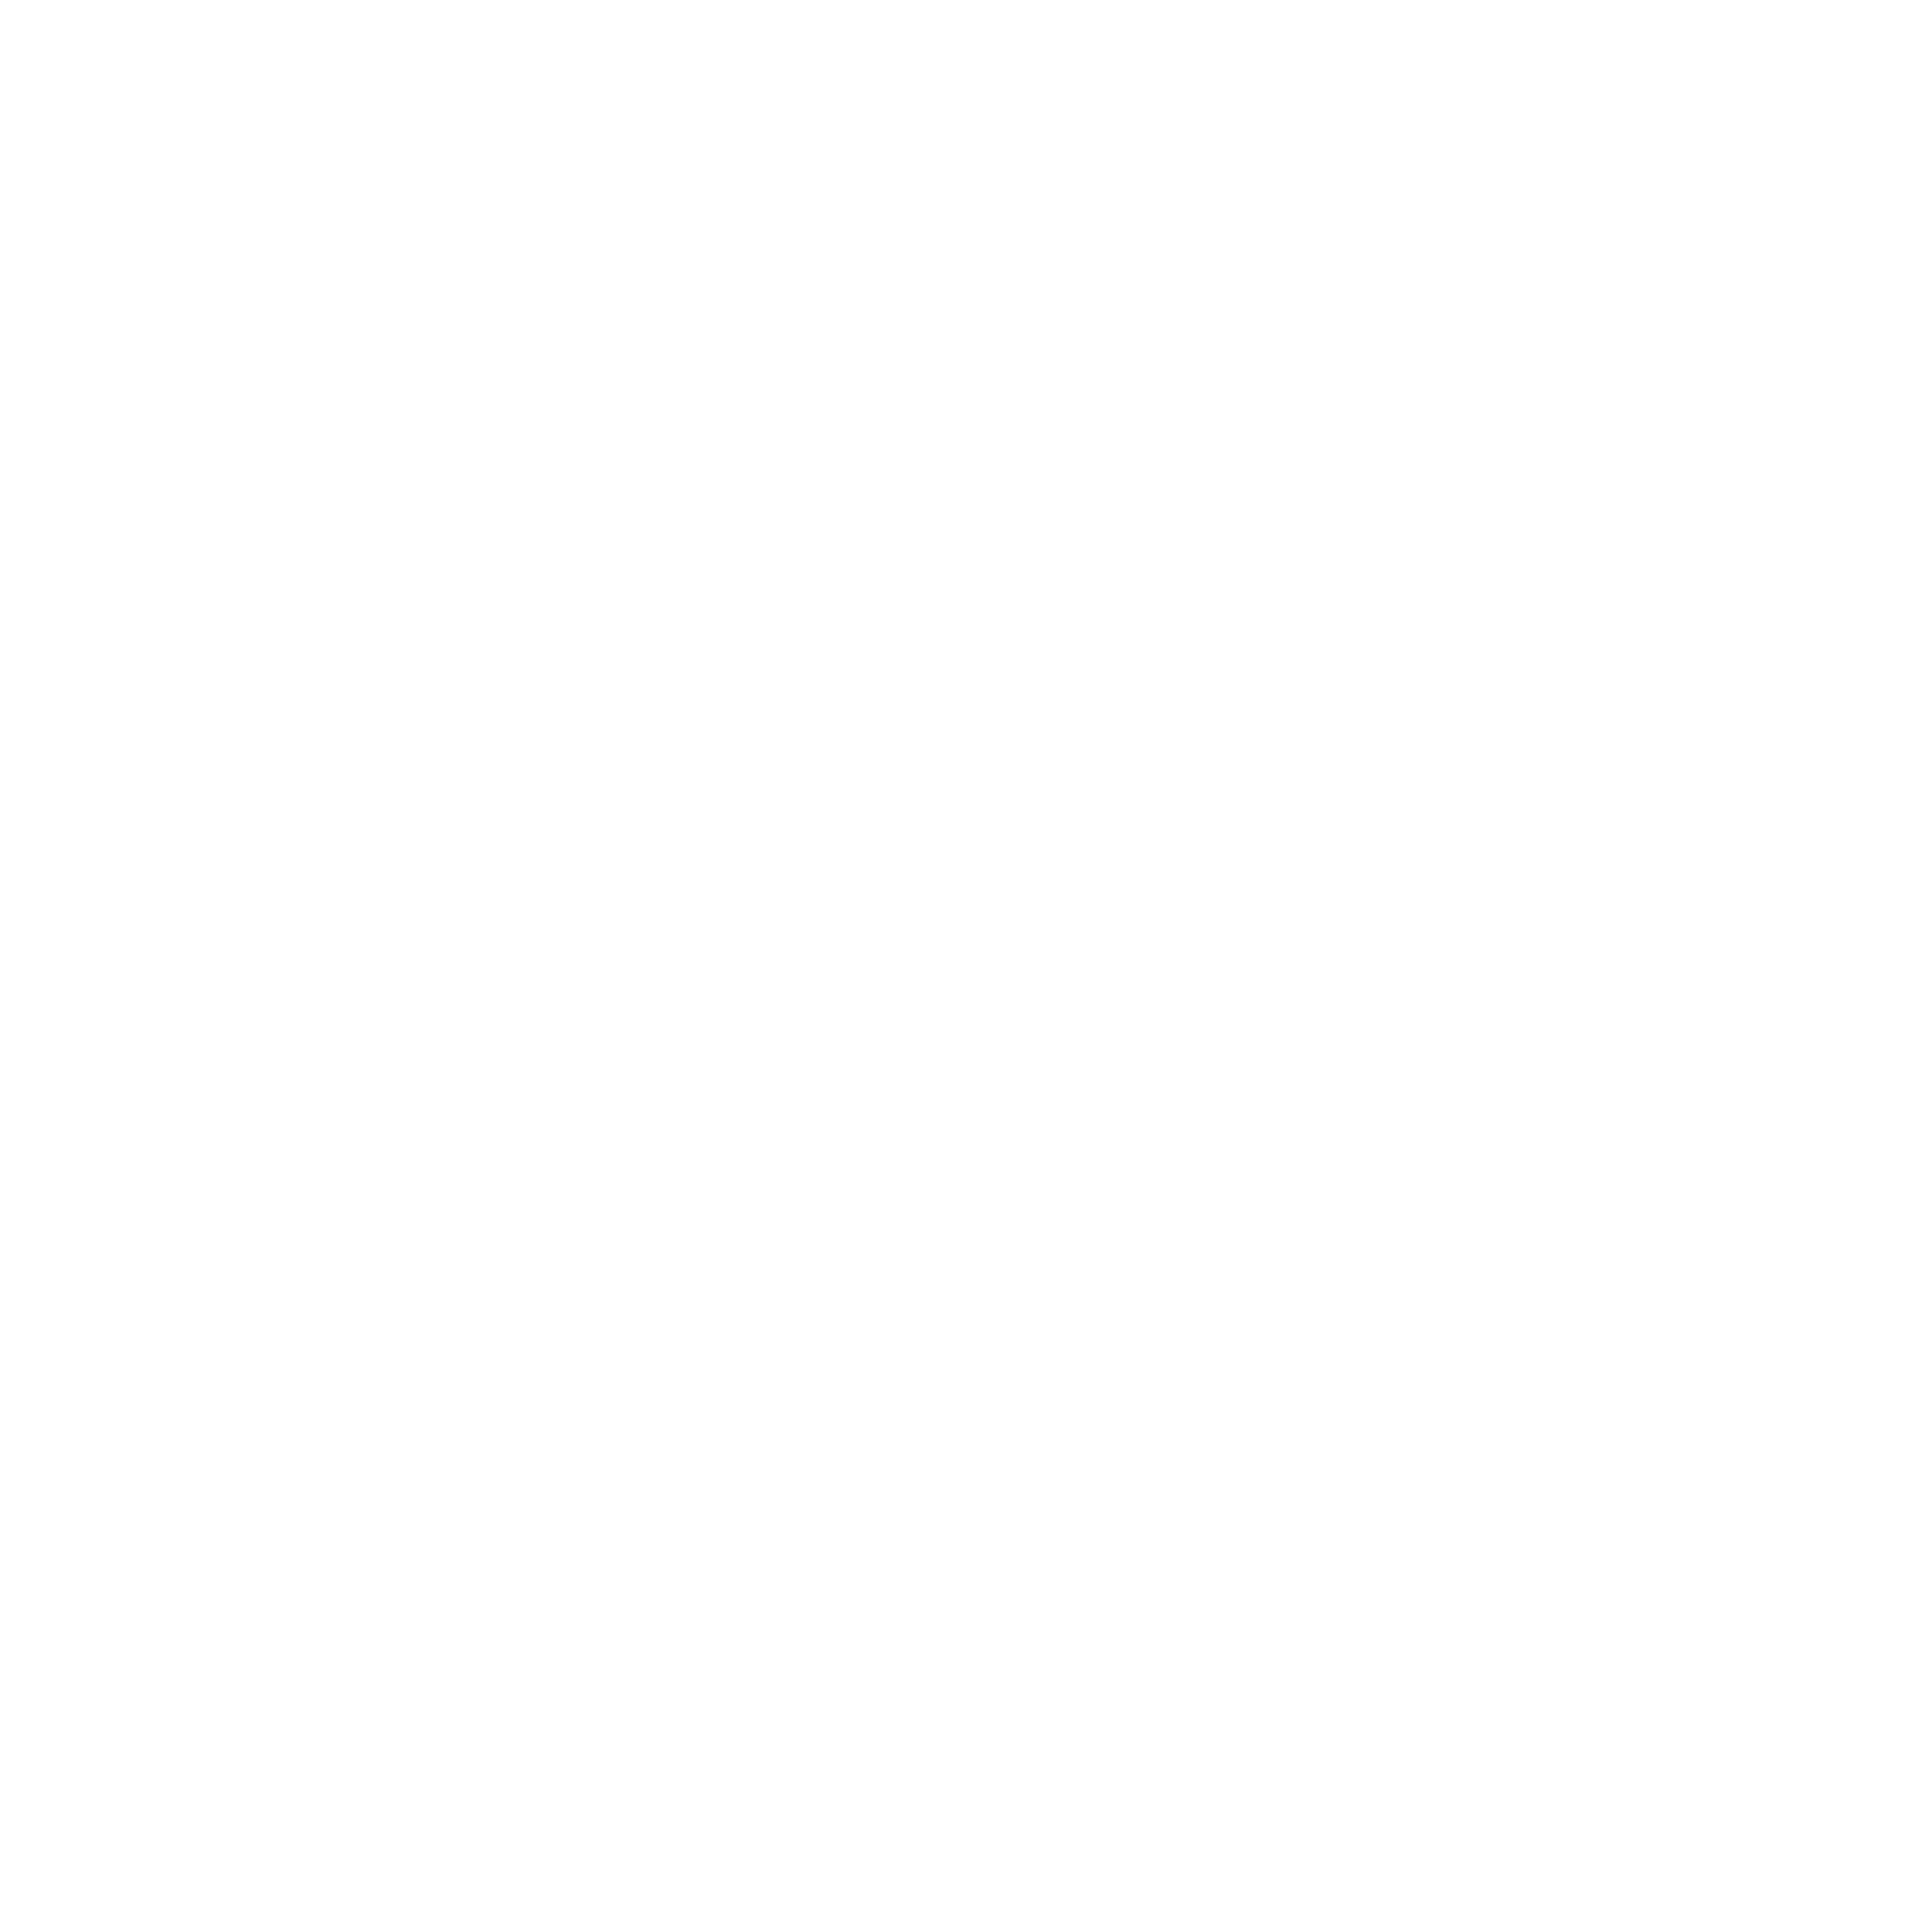

Saved image!


In [160]:
x,y=test_model_on_image_pair(r2,c2,box2,box1,save_dir="E:/nSm/DenseMatching/evaluation/",path_to_pre_trained_models="E:/nSm/DenseMatching/pre_trained_models/")

In [161]:
x,y

(103.92792, 95.08937)

In [162]:
centroidFoundXY=tL2[0]+x,y+tL2[1]
centroidFoundXY

(5930.927917480469, 2955.089370727539)

<IPython.core.display.Javascript object>


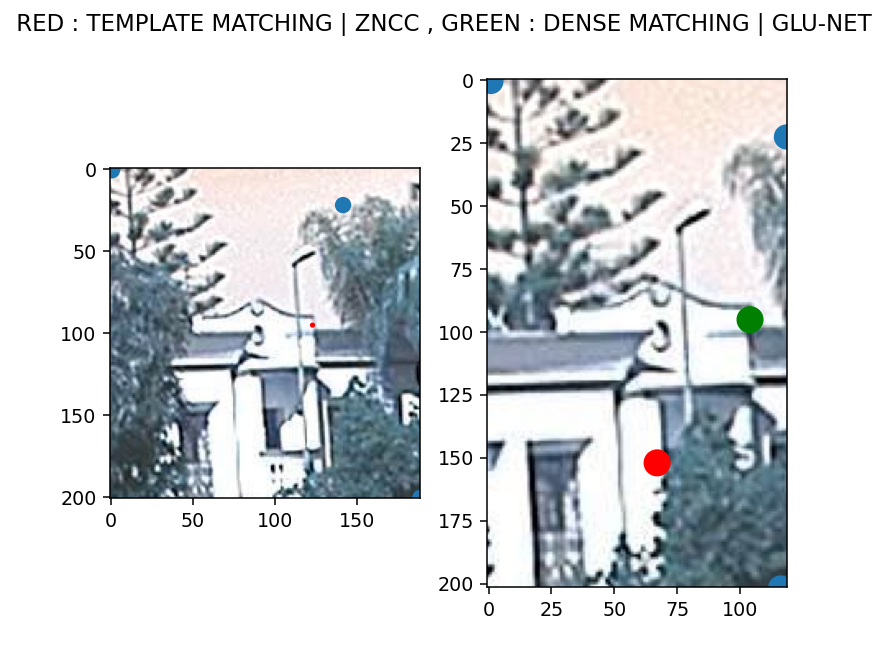

Text(0.5, 0.98, ' RED : TEMPLATE MATCHING | ZNCC , GREEN : DENSE MATCHING | GLU-NET')

In [163]:
%matplotlib notebook
bCop1=box1c.copy()
bCop2=box2c.copy()

fig,ax=plt.subplots(1,2)
ax[0].imshow(bCop1)
for key in kpP1:
    ax[0].add_patch(Circle(key-tL1))
ax[0].add_patch(Circle(np.array([row,col])-tL1,1,color='red'))

    
ax[1].imshow(bCop2)
for key in kpP2:
    ax[1].add_patch(Circle(key-tL2))
# for centroidFoundB2 in centroidFoundB2s:
ax[1].add_patch(Circle(centroidFoundB2,color='red'))
# bbs

ax[1].add_patch(Circle((x,y),color='green'))
fig.suptitle(" RED : TEMPLATE MATCHING | ZNCC , GREEN : DENSE MATCHING | GLU-NET")

<IPython.core.display.Javascript object>


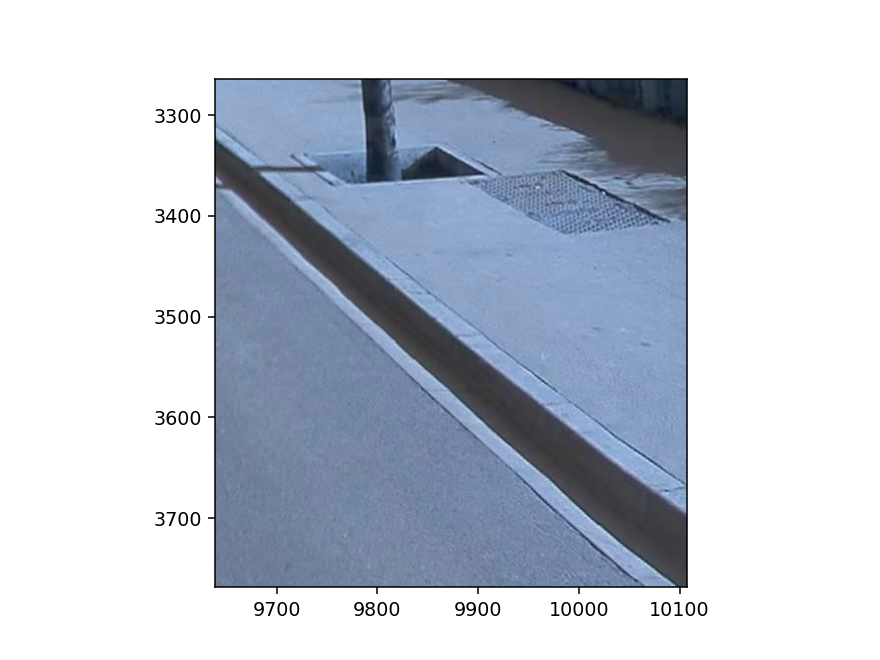

In [199]:
%matplotlib notebook
fig,ax=plt.subplots(1)
ax.imshow(image1)

In [215]:
cv2.imwrite("E:/nSm/DenseMatching/test_input/box1.png",box1)
cv2.imwrite("E:/nSm/DenseMatching/test_input/box2.png",box2)

True

In [31]:
img=temp
patchSize=3
tempcc=img[0:img.shape[0]-img.shape[0]%patchSize,0:img.shape[1]-img.shape[1]%patchSize,:]
cv2.imwrite("E:/nSm/tempMatchAlgo/BBS/data/templates/temp.png",tempcc)
img=box2
patchSize=3
box2cc=img[0:img.shape[0]-img.shape[0]%patchSize,0:img.shape[1]-img.shape[1]%patchSize,:]
cv2.imwrite("E:/nSm/tempMatchAlgo/BBS/data/images/box.png",box2cc)
cv2.imwrite("E:/nSm/tempMatchAlgo/BBS/data/images/box_w.png",box2)

True

In [55]:
##problems

In [57]:
kp23=featuresCoorDen[data.image_list[1]][matches[(data.image_list[2],data.image_list[1])][:,1]]
kp32=featuresCoorDen[data.image_list[2]][matches[(data.image_list[2],data.image_list[1])][:,0]]

In [126]:
#data
kp1=featuresCoorDen[data.image_list[0]][matches[(data.image_list[1],data.image_list[0])][:,1]]
kp2=featuresCoorDen[data.image_list[1]][matches[(data.image_list[1],data.image_list[0])][:,0]]

# kp1=np.unique(kp1,axis=0)
# kp2=np.unique(kp2,axis=0)

image1,image2=images[0],images[1]

kp1=np.append(kp1,np.array([[0,0],[0,image1.shape[0]-1],[image1.shape[1]-1,0],[image1.shape[1]-1,image1.shape[0]-1]]),axis=0)
kp2=np.append(kp2,np.array([[0,0],[0,image2.shape[0]-1],[image2.shape[1]-1,0],[image2.shape[1]-1,image2.shape[0]-1]]),axis=0)

kpg1=kp1
kpg2=kp2
imageG1,imageG2=image1,image2

# row,col=centroidFoundXY 
# row,col=int(row),int(col)
row,col=2386,3609
scale=1

# mask=getClosestKeyPoints(row,col,kp1,3)
# mask=getClosestSurrondingPoints(row,col,kp1,3)



if not in_hull(kpg1,row,col):
    raise Exception("point not inside the convex hull")
    
tri = Delaunay(kpg1)    
mask=findindingClosest3Points(row,col,kpg1,tri)

if mask.any()==-1:
    raise Exception("triangulation didnt find any simplex/try with another method")

kpP1=kpg1[mask]
kpP2=kpg2[mask]

print("shape {}".format(kpP1.shape))
#additionnal step
# l=np.argsort(np.sum((kpP1-np.array([[row,col]]))**2,axis=1))[0:min(6,kpP1.shape[0])]
# kpP1=kpP1[l]
# kpP2=kpP2[l]

print("r",kpP1)

# coordinates of the bounding boxes
tL1,br1=getBoundingBox(kpP1)
tL2,br2=getBoundingBox(kpP2)


#boxes -> images


box1,box2=fromBbToImage(imageG1,tL1,br1),fromBbToImage(imageG2,tL2,br2)

r2,c2=row-tL1[0],col-tL1[1]
print(tL1)

    
print(tL1,br1)
#choosing a window centered in the point that have dimensions smaller than the bounding box
kernelD=40
#new coordinates in the first box
# r2,c2=row-tL1[0],col-tL1[1]
print(r2,c2)
# while r2-kernelD<0 or c2-kernelD<0 or r2+kernelD>=br1[0]-tL1[0] or c2+kernelD>=br1[1]-tL1[1] :
#     kernelD-=1

# temp=returnWindow(image1,kernelD,row,col)

# print(kernelD)

kernelDR=40
kernelDC=50
while r2-kernelDR<0 or r2+kernelDR>=br1[0]-tL1[0] :
    kernelDR-=1

while c2-kernelDC<0 or c2+kernelDC>=br1[1]-tL1[1] :
    kernelDC-=1

temp=returnWindowRectangle(image1,kernelDR,kernelDC,row,col)
print(kernelDR,kernelDC)


#instead of getting template straight out of the mother image,we should get it from reformated box
# boxc1=blurShadow(box1,5)
temp=returnWindowRectangle(box1,kernelDR,kernelDC,r2,c2)
print("shape",temp.shape)
# kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) 

# kernel = np.ones((9,9),np.float32)/81


# temp = cv2.filter2D(temp,-1,kernel)
# box2= cv2.filter2D(box2,-1,kernel)

# box2=histoEqualization(box2)
# temp=histoEqualization(temp)

# temp=cv2.medianBlur(temp,9)
# box2=cv2.medianBlur(box2,9)

# temp=cv.bilateralFilter(src, i, i * 2, i / 2)

##since correlation is normalised contrast and brightness wouldnt solve the problem
# alpha,beta=1,70
# temp=cv2.convertScaleAbs(temp, alpha=alpha, beta=beta) 
# box2=cv2.convertScaleAbs(box2, alpha=alpha, beta=beta) 

#coorelation template based matching test:
# res=cv2.matchTemplate(box2,temp,cv2.TM_CCOEFF_NORMED)

temp0=temp.copy()


# morphological operations dilatation / erosion

kernel = np.ones((temp.shape[0]//2,temp.shape[0]//2),np.uint8)

# temp=cv2.bilateralFilter(temp,20,75,75)
# box2c=cv2.bilateralFilter(box2,20,75,75)
# temp=cv2.dilate(temp,kernel,iterations = 1)
# box2c=cv2.dilate(box2,kernel,iterations =1)

# # # cv2.MORPH_GRADIENT cv2.MORPH_OPEN
# temp=cv2.morphologyEx(temp,cv2.MORPH_OPEN, kernel)
# box2c=cv2.morphologyEx(box2,cv2.MORPH_OPEN, kernel)

# temp=cv2.Canny(temp,40,100)
# box2c=cv2.Canny(temp,40,100)


# box2c=edgeDetection(box2,1,0,ddepth=cv2.CV_64F)
# tempc=edgeDetection(temp,1,0,ddepth=cv2.CV_64F)
# box2c=blurShadow(box2,5)
# tempc=blurShadow(temp,3,50,50)
res=cv2.matchTemplate(box2,temp,cv2.TM_CCOEFF_NORMED)
box2c=box2
box1c=box1

print(box2.shape,res.shape)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

# threshold = 0.74
# loc = np.where( res >= threshold)

# loc=np.where(res>(np.sort(res,axis=None)[::-1][min(1,res.shape[0])]))

# print((np.sort(res,axis=None)[::-1][min(1,res.shape[0])]))
# closestKeyMask=getClosestKeyPoints(row,col,kp1,1)
# closestK1=kp1[closestKeyMask]
# closestK2=kp2[closestKeyMask]
# ciSearch=(closestK2-tL2-np.array([temp.shape[1]-1,temp.shape[0]-1])).astype(int)

# # print(ciSearch)
# radius=100
# fl=res[ciSearch[0,0]-radius:ciSearch[0,0]+radius,ciSearch[0,1]-radius:ciSearch[0,1]+radius]
# max_loc2=cv2.minMaxLoc(fl)[3]
# max_loc2=max_loc2[0]+ciSearch[0,0]-radius,+max_loc2[1]+ciSearch[0,1]-radius

# max_loc=max_loc2

centroidFoundB2=max_loc[0]+(temp.shape[1]*scale)/2,max_loc[1]+(temp.shape[0]*scale)/2
centroidFound=centroidFoundB2[0]+tL2[0],centroidFoundB2[1]+tL2[1]

# centroidFoundB2s=[(pt[0]+(temp.shape[1]*scale)/2,pt[1]+(temp.shape[0]*scale)/2) for pt in zip(*loc[::-1])]

# print(centroidFound)

[ 95 108 137 256 222 137  95 222 171]
[ 95 108 137 256 222 137  95 222 171 222  95 137]
[222  95 137] [ 95 108 137 171 222 256]
shape (3, 2)
r [[2170.83276367 3478.56616211]
 [2583.84106445 3425.04931641]
 [2391.29541016 3720.54833984]]
(2170, 3425)
(2170, 3425) (2584, 3721)
216 184
40 50
shape (100, 80, 3)
(147, 276, 3) (48, 197)


Model: GLUNet
Pre-trained-model: dynamic
before padding 
(147, 276, 3) (296, 414, 3)
after padding
149 138
0 0
(296, 414, 3) (296, 414, 3)
query shape (147, 276, 3) , reference shape (296, 414, 3) , map shape (296, 414, 3)
(296, 414, 2) [[  -2.4267147   -2.4267147   -2.4824011 ...   -6.0411506   -6.0333014
    -6.0333014]
 [  -2.4267147   -2.4267147   -2.4824011 ...   -6.0411506   -6.0333014
    -6.0333014]
 [  -2.3812666   -2.3812666   -2.4474826 ...   -6.220311    -6.2242293
    -6.2242293]
 ...
 [-179.72757   -179.72757   -180.4385    ... -146.60284   -147.1898
  -147.1898   ]
 [-179.01859   -179.01859   -179.79633   ... -145.58672   -146.08861
  -146.08861  ]
 [-179.01859   -179.01859   -179.79633   ... -145.58672   -146.08861
  -146.08861  ]]


<IPython.core.display.Javascript object>


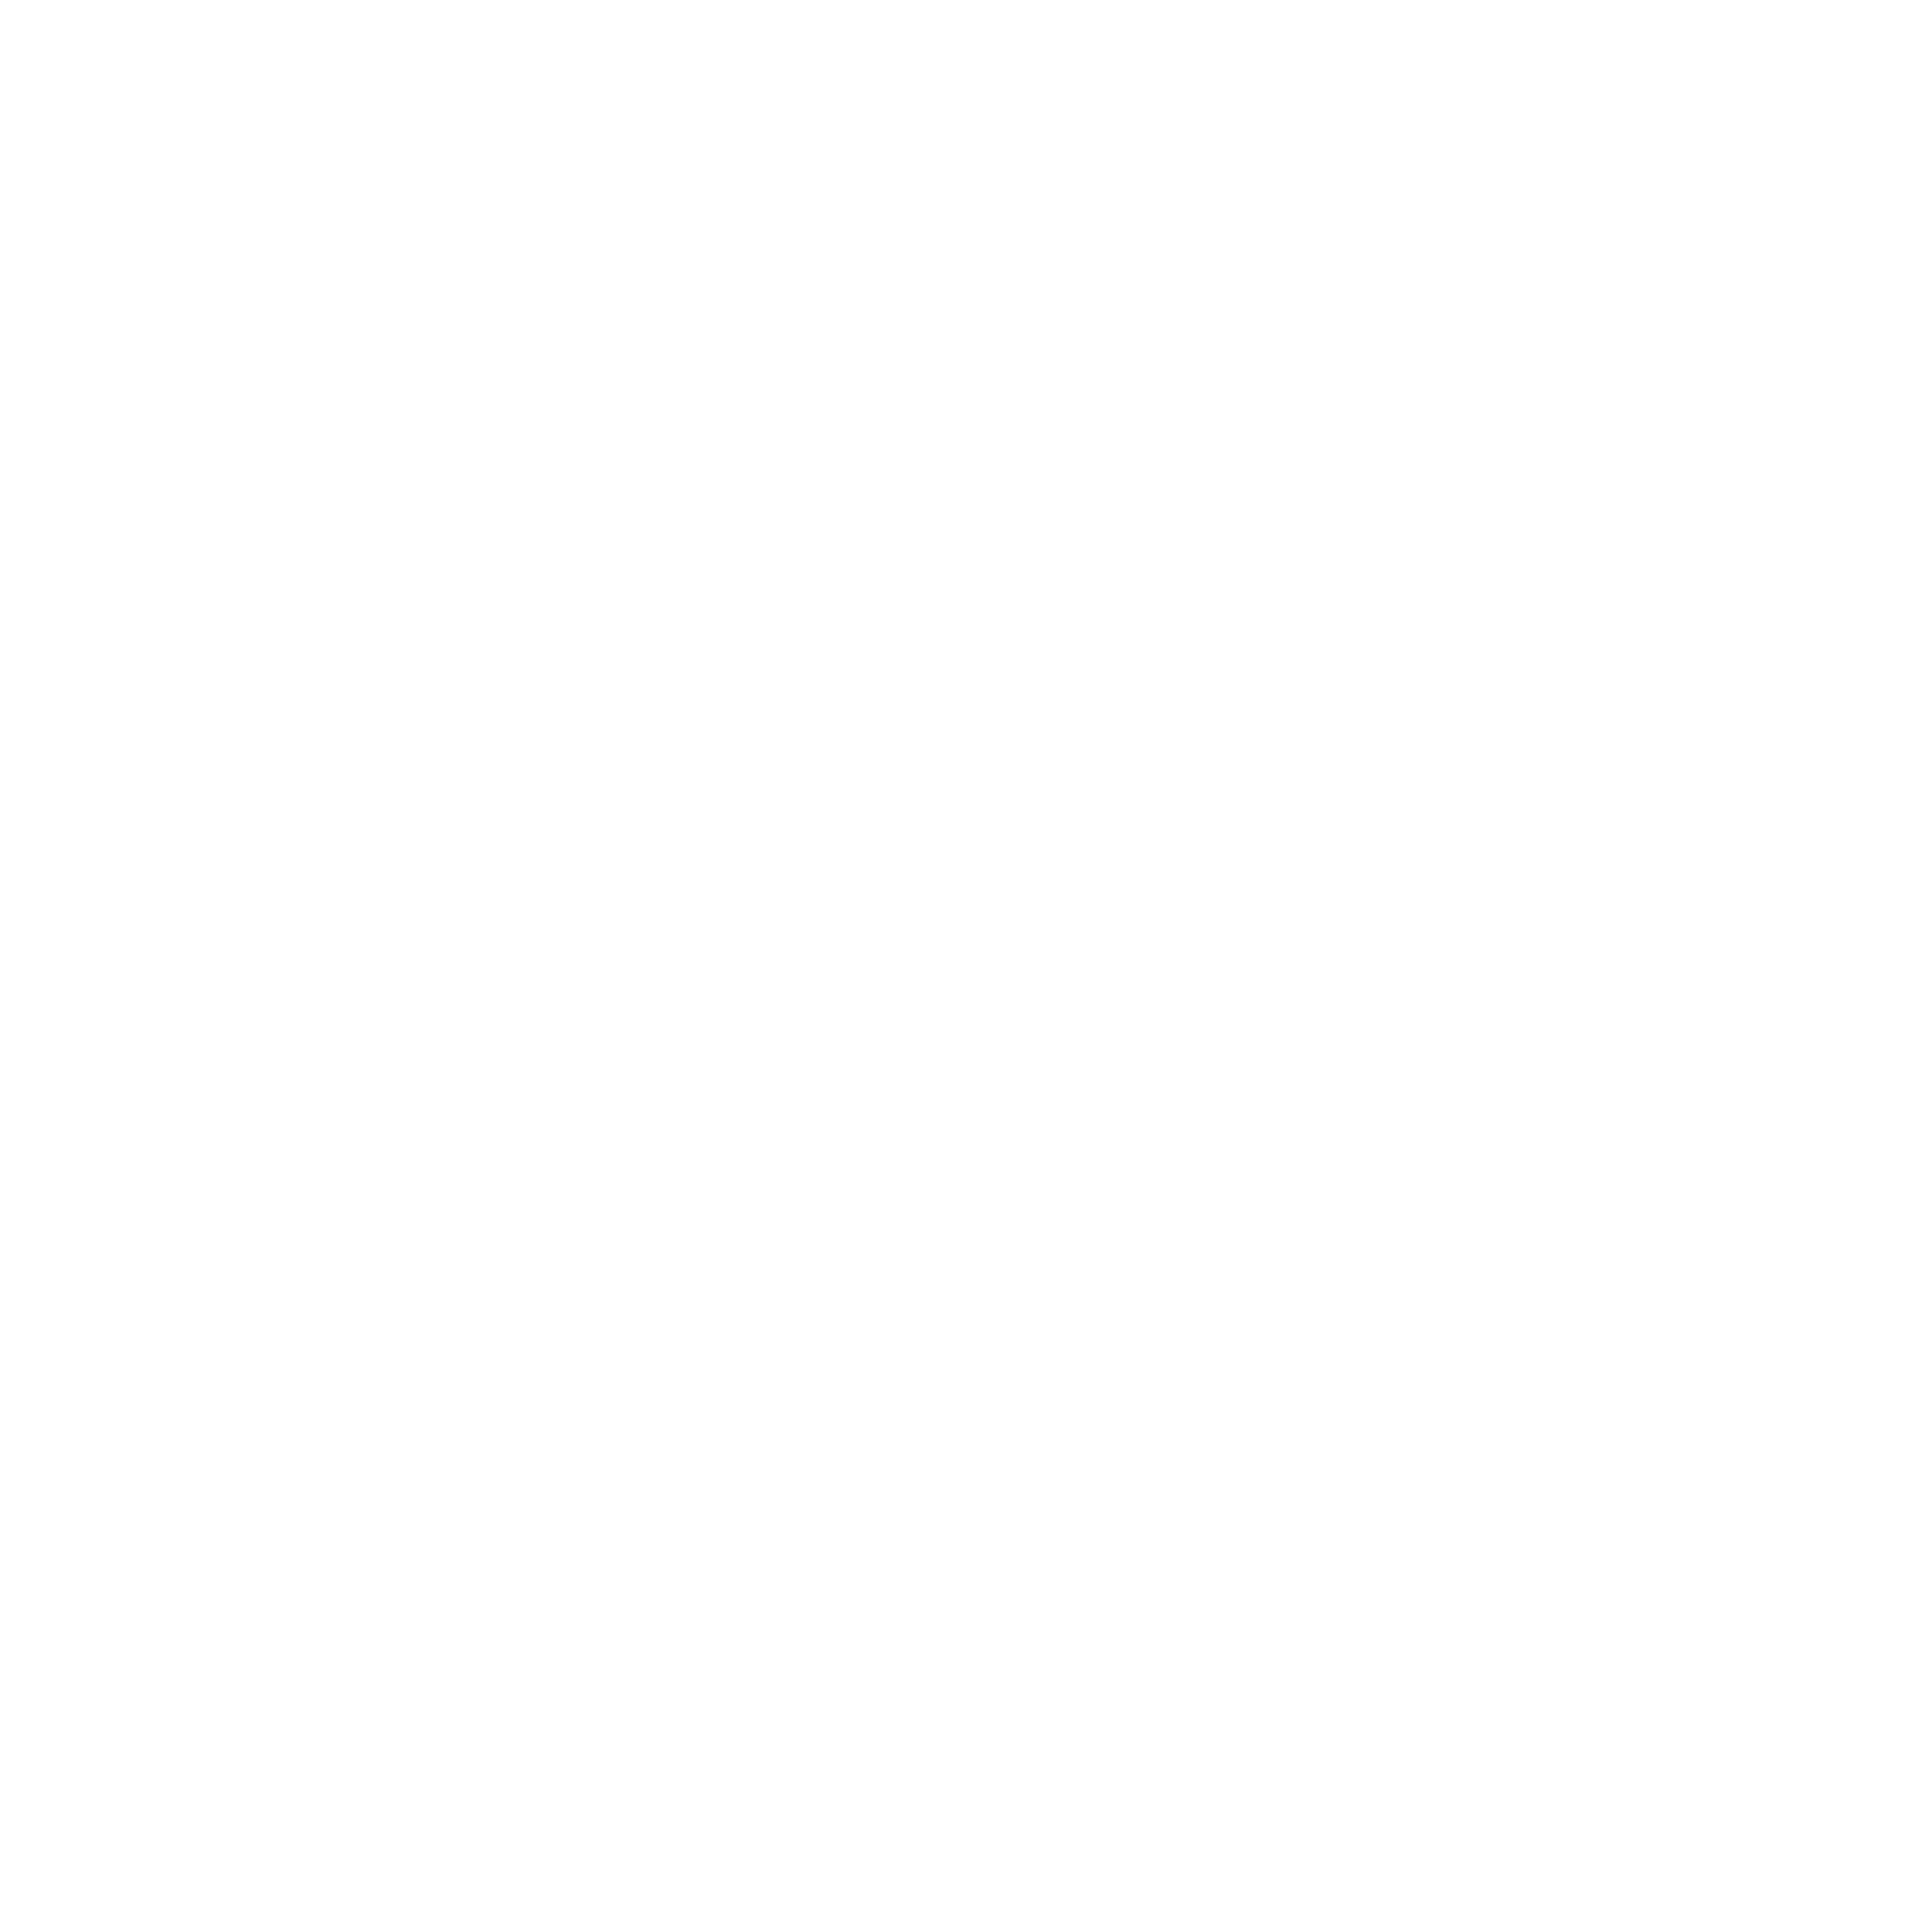

Saved image!


In [127]:
x,y=test_model_on_image_pair(r2,c2,box2,box1,save_dir="E:/nSm/DenseMatching/evaluation/",path_to_pre_trained_models="E:/nSm/DenseMatching/pre_trained_models/")

<IPython.core.display.Javascript object>


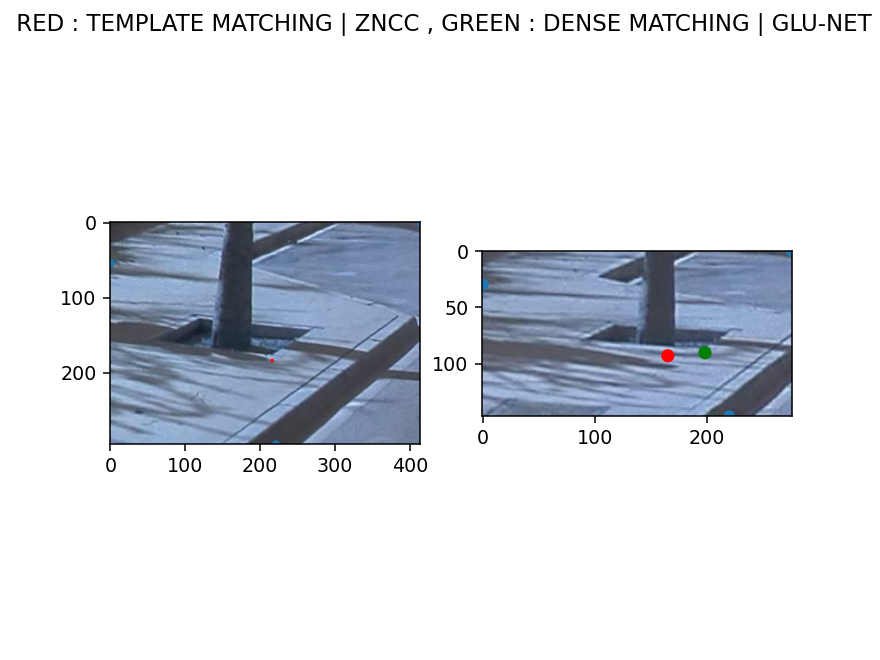

Text(0.5, 0.98, ' RED : TEMPLATE MATCHING | ZNCC , GREEN : DENSE MATCHING | GLU-NET')

In [128]:
%matplotlib notebook
bCop1=box1c.copy()
bCop2=box2c.copy()

fig,ax=plt.subplots(1,2)
ax[0].imshow(bCop1)
for key in kpP1:
    ax[0].add_patch(Circle(key-tL1))
ax[0].add_patch(Circle(np.array([row,col])-tL1,1,color='red'))

    
ax[1].imshow(bCop2)
for key in kpP2:
    ax[1].add_patch(Circle(key-tL2))
# for centroidFoundB2 in centroidFoundB2s:
ax[1].add_patch(Circle(centroidFoundB2,color='red'))
# bbs

ax[1].add_patch(Circle((x,y),color='green'))
fig.suptitle(" RED : TEMPLATE MATCHING | ZNCC , GREEN : DENSE MATCHING | GLU-NET")

In [68]:
import gc,torch

gc.collect()

torch.cuda.empty_cache()

In [93]:
#data
kp23=featuresCoorDen[data.image_list[1]][matches[(data.image_list[2],data.image_list[1])][:,1]]
kp32=featuresCoorDen[data.image_list[2]][matches[(data.image_list[2],data.image_list[1])][:,0]]

# kp1=np.unique(kp1,axis=0)
# kp2=np.unique(kp2,axis=0)

image1,image2=images[1],images[2]

kp23=np.append(kp23,np.array([[0,0],[0,image1.shape[0]-1],[image1.shape[1]-1,0],[image1.shape[1]-1,image1.shape[0]-1]]),axis=0)
kp32=np.append(kp32,np.array([[0,0],[0,image2.shape[0]-1],[image2.shape[1]-1,0],[image2.shape[1]-1,image2.shape[0]-1]]),axis=0)

kpg1=kp23
kpg2=kp32
imageG1,imageG2=image1,image2

row,col=centroidFoundXY 
row,col=int(row),int(col)

scale=1

# mask=getClosestKeyPoints(row,col,kp1,3)
# mask=getClosestSurrondingPoints(row,col,kp1,3)



if not in_hull(kpg1,row,col):
    raise Exception("point not inside the convex hull")
    
tri = Delaunay(kpg1)    
mask=findindingClosest3Points(row,col,kpg1,tri)

if mask.any()==-1:
    raise Exception("triangulation didnt find any simplex/try with another method")

kpP1=kpg1[mask]
kpP2=kpg2[mask]

print("shape {}".format(kpP1.shape))
#additionnal step
# l=np.argsort(np.sum((kpP1-np.array([[row,col]]))**2,axis=1))[0:min(6,kpP1.shape[0])]
# kpP1=kpP1[l]
# kpP2=kpP2[l]

print("r",kpP1)

# coordinates of the bounding boxes
tL1,br1=getBoundingBox(kpP1)
tL2,br2=getBoundingBox(kpP2)


#boxes -> images


box1,box2=fromBbToImage(imageG1,tL1,br1),fromBbToImage(imageG2,tL2,br2)

#choosing a window centered in the point that have dimensions smaller than the bounding box
kernelD=40
#new coordinates in the first box
r2,c2=row-tL1[0],col-tL1[1]
print(r2,c2)
# while r2-kernelD<0 or c2-kernelD<0 or r2+kernelD>=br1[0]-tL1[0] or c2+kernelD>=br1[1]-tL1[1] :
#     kernelD-=1

# temp=returnWindow(image1,kernelD,row,col)

# print(kernelD)

kernelDR=40
kernelDC=50
while r2-kernelDR<0 or r2+kernelDR>=br1[0]-tL1[0] :
    kernelDR-=1

while c2-kernelDC<0 or c2+kernelDC>=br1[1]-tL1[1] :
    kernelDC-=1

temp=returnWindowRectangle(image1,kernelDR,kernelDC,row,col)
print(kernelDR,kernelDC)


#instead of getting template straight out of the mother image,we should get it from reformated box
# boxc1=blurShadow(box1,5)
temp=returnWindowRectangle(box1,kernelDR,kernelDC,r2,c2)

# kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) 

# kernel = np.ones((9,9),np.float32)/81


# temp = cv2.filter2D(temp,-1,kernel)
# box2= cv2.filter2D(box2,-1,kernel)

# box2=histoEqualization(box2)
# temp=histoEqualization(temp)

# temp=cv2.medianBlur(temp,9)
# box2=cv2.medianBlur(box2,9)

# temp=cv.bilateralFilter(src, i, i * 2, i / 2)

##since correlation is normalised contrast and brightness wouldnt solve the problem
# alpha,beta=1,70
# temp=cv2.convertScaleAbs(temp, alpha=alpha, beta=beta) 
# box2=cv2.convertScaleAbs(box2, alpha=alpha, beta=beta) 

#coorelation template based matching test:
# res=cv2.matchTemplate(box2,temp,cv2.TM_CCOEFF_NORMED)

temp0=temp.copy()


# morphological operations dilatation / erosion

kernel = np.ones((temp.shape[0]//2,temp.shape[0]//2),np.uint8)

# temp=cv2.bilateralFilter(temp,20,75,75)
# box2c=cv2.bilateralFilter(box2,20,75,75)
# temp=cv2.dilate(temp,kernel,iterations = 1)
# box2c=cv2.dilate(box2,kernel,iterations =1)

# # # cv2.MORPH_GRADIENT cv2.MORPH_OPEN
# temp=cv2.morphologyEx(temp,cv2.MORPH_OPEN, kernel)
# box2c=cv2.morphologyEx(box2,cv2.MORPH_OPEN, kernel)

# temp=cv2.Canny(temp,40,100)
# box2c=cv2.Canny(temp,40,100)


# box2c=edgeDetection(box2,1,0,ddepth=cv2.CV_64F)
# tempc=edgeDetection(temp,1,0,ddepth=cv2.CV_64F)
# box2c=blurShadow(box2,5)
# tempc=blurShadow(temp,3,50,50)
res=cv2.matchTemplate(box2,temp,cv2.TM_CCOEFF_NORMED)
box2c=box2
box1c=box1

print(box2.shape,res.shape)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

# threshold = 0.74
# loc = np.where( res >= threshold)

# loc=np.where(res>(np.sort(res,axis=None)[::-1][min(1,res.shape[0])]))

# print((np.sort(res,axis=None)[::-1][min(1,res.shape[0])]))
# closestKeyMask=getClosestKeyPoints(row,col,kp1,1)
# closestK1=kp1[closestKeyMask]
# closestK2=kp2[closestKeyMask]
# ciSearch=(closestK2-tL2-np.array([temp.shape[1]-1,temp.shape[0]-1])).astype(int)

# # print(ciSearch)
# radius=100
# fl=res[ciSearch[0,0]-radius:ciSearch[0,0]+radius,ciSearch[0,1]-radius:ciSearch[0,1]+radius]
# max_loc2=cv2.minMaxLoc(fl)[3]
# max_loc2=max_loc2[0]+ciSearch[0,0]-radius,+max_loc2[1]+ciSearch[0,1]-radius

# max_loc=max_loc2

centroidFoundB2=max_loc[0]+(temp.shape[1]*scale)/2,max_loc[1]+(temp.shape[0]*scale)/2
centroidFound=centroidFoundB2[0]+tL2[0],centroidFoundB2[1]+tL2[1]

# centroidFoundB2s=[(pt[0]+(temp.shape[1]*scale)/2,pt[1]+(temp.shape[0]*scale)/2) for pt in zip(*loc[::-1])]

# print(centroidFound)

[124 206  46  41  46 259 124  41 247]
[124 206  46  41  46 259 124  41 247  41 124  46]
[ 41 124  46] [ 41  46 124 206 247 259]
shape (3, 2)
r [[2509.52954102 3597.66845703]
 [2568.30786133 3426.12011719]
 [2688.29174805 3428.85083008]]
100 21
40 21
(108, 106, 3) (67, 27)


Model: GLUNet
Pre-trained-model: dynamic
before padding 
(108, 106, 3) (172, 180, 3)
after padding
64 74
0 0
(172, 180, 3) (172, 180, 3)
query shape (108, 106, 3) , reference shape (172, 180, 3) , map shape (172, 180, 3)
(172, 180, 2) [[  2.471773    2.4352896   2.0461369 ...   1.3594906   1.4151824
    1.4204036]
 [  2.3079908   2.2723572   1.8922689 ...   1.3766912   1.4614863
    1.4694359]
 [  1.2597853   1.2295907   0.9075151 ...   1.4867756   1.7578323
    1.7832438]
 ...
 [-74.35859   -74.36598   -74.44489   ... -59.122543  -58.677643
  -58.63594  ]
 [-74.35691   -74.37189   -74.53173   ... -58.231373  -57.39069
  -57.311874 ]
 [-74.35664   -74.37281   -74.545296  ... -58.092125  -57.1896
  -57.10499  ]]


<IPython.core.display.Javascript object>


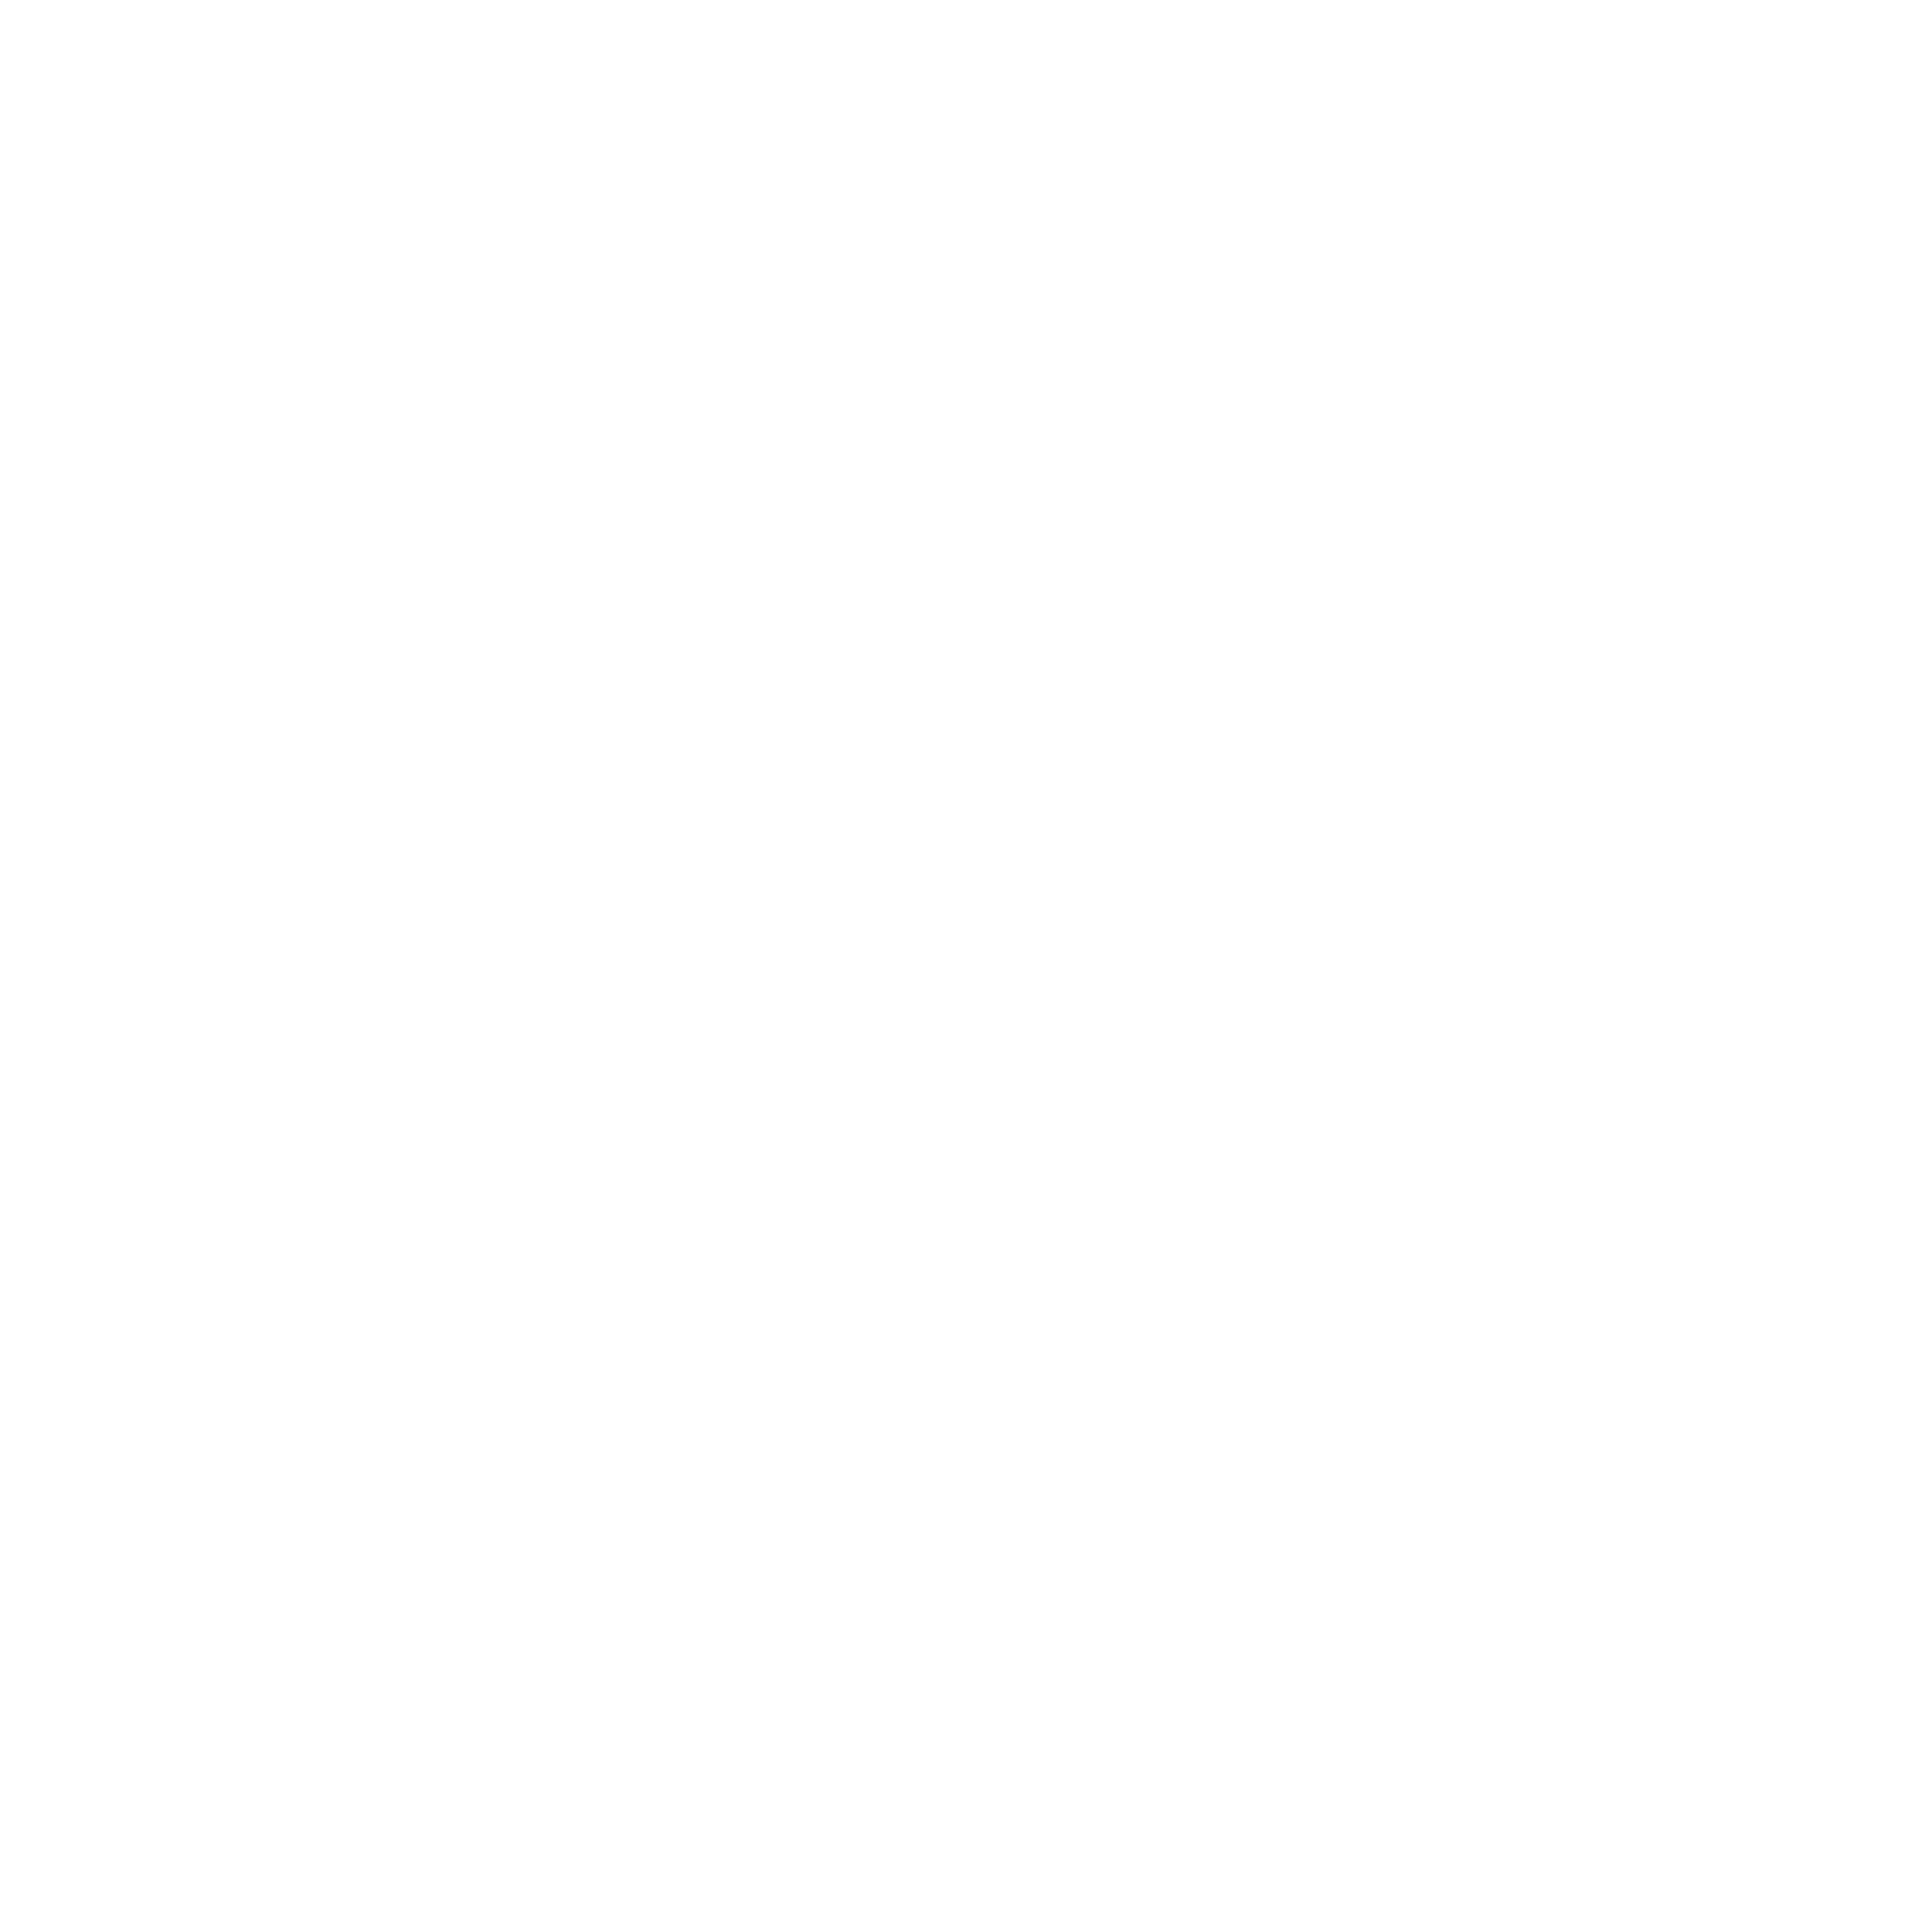

Saved image!


In [94]:
x,y=test_model_on_image_pair(r2,c2,box2,box1,save_dir="E:/nSm/DenseMatching/evaluation/",path_to_pre_trained_models="E:/nSm/DenseMatching/pre_trained_models/")

<IPython.core.display.Javascript object>


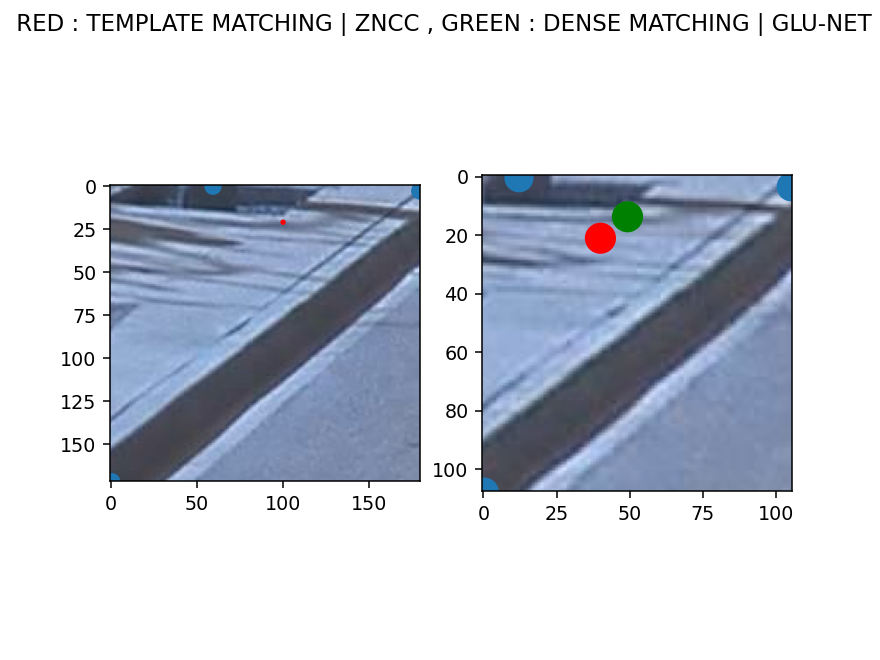

Text(0.5, 0.98, ' RED : TEMPLATE MATCHING | ZNCC , GREEN : DENSE MATCHING | GLU-NET')

In [99]:
%matplotlib notebook
bCop1=box1c.copy()
bCop2=box2c.copy()

fig,ax=plt.subplots(1,2)
ax[0].imshow(bCop1)
for key in kpP1:
    ax[0].add_patch(Circle(key-tL1))
ax[0].add_patch(Circle(np.array([row,col])-tL1,1,color='red'))

    
ax[1].imshow(bCop2)
for key in kpP2:
    ax[1].add_patch(Circle(key-tL2))
# for centroidFoundB2 in centroidFoundB2s:
ax[1].add_patch(Circle(centroidFoundB2,color='red'))
# bbs

ax[1].add_patch(Circle((x,y),color='green'))
fig.suptitle(" RED : TEMPLATE MATCHING | ZNCC , GREEN : DENSE MATCHING | GLU-NET")

In [ ]:
# rotation1=np.array([1.5029111398666053,0.5929701592087059,-0.7006966781389913])
# translation1=np.array([174.07608666828153,108.55407843012178,-14.681897217530219])
# pos=np.array([2386,3609,1])

In [100]:
boxc1,boxc2=box1.copy(),box2.copy()

In [102]:
boxc1.shape,boxc2.shape

((172, 180, 3), (108, 106, 3))

In [103]:
boxc1=cv2.resize(boxc1,boxc2.shape[:2],interpolation = cv2.INTER_CUBIC)

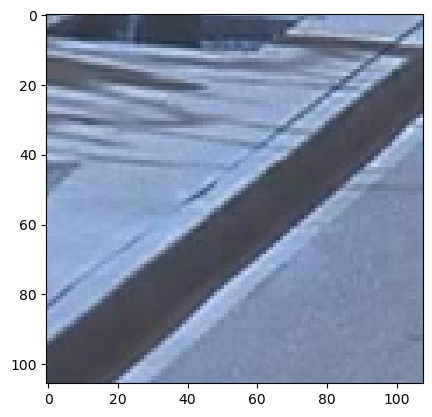

In [104]:
%matplotlib inline
plt.imshow(boxc1)